# REINFORCE Algorithm

In [1]:
%load_ext autoreload
%autoreload 2

https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

# Instalación de librería gym

https://gym.openai.com/

pip install gym

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym

![alt_text](reinforcement_diagram.png)

$$\huge max_{\theta} \quad\mathbb{E_{\pi_{\theta}}}\{\sum_{t=0}^{T}R(s_t, a_t)\}$$

Donde R es la recompensa que se recibirá luego de la acción $a_t$ estando en el estado $s_t$

$$\huge R(\tau) = \sum_{t=0}^{T}R(s_t, a_t)\$$

$$\huge J_{\theta} = \sum_{\tau} P(\tau, \theta) R(\tau)$$

$P(\tau, \theta)$ es la probabilidad de una trayectoria dada la policy y contiene el modelo $P(s_i|a_i, s_{i-1})$ y también la policy $\pi_{\theta}(a_i|s_i)$

$$\huge P(\tau, \theta) = \prod_{t=0}^T P(s_{t+1}|a_t, s_{t}) \pi_{\theta}(a_t|s_t)$$

![](Markov_Decision_Process.svg.png)

# Cart Pole problem

![alt text](cart_pole.gif "Title")

In [3]:
env = gym.make("CartPole-v0")

# REINFORCE. Algoritmo

## 1. Inicializar red neuronal con pesos aleatorios: $\large \pi_{\theta}(a_t|s_t)$
## 2. Correr un episodio y guardar estados ($s_t$), acciones ($a_t$) y rewards ($r_t$)
## 3. Calcular la suma de los discounted rewards:
$$ \huge G_t = \sum_{t'=t+1}^T \gamma^{t'-t-1} r_{t'}$$
## 4. Calcular el gradiente:
$$\huge \nabla_{\theta}J(\theta) = \sum_{t=0}^{T-1}{\nabla_{\theta} log \pi_{\theta}}(a_t|s_t)G_t$$
## 5. Tomar un paso en dirección del gradiente (Queremos maximizar)
$$ \huge \theta = \theta + \alpha \nabla_{\theta}J(\theta) $$
## 6. Repetir desde el paso 2 hasta convergencia

# Toy example

In [4]:
actions = [[1., 0.], [0., 1.], [0, 1], [1, 0]]
pi_outs = [[.9, .1], [.4, .6], [0.2, 0.8], [0.3, 0.7]]
discounted_rewards = [12.24, 11.36, 10.466, 9.56]

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
actions = tf.constant(actions, shape=[4,2])
pi = tf.constant(pi_outs, shape=[4,2])
discounted_rewards = tf.constant(discounted_rewards, shape=[4,1])
product = discounted_rewards*actions
loss = K.categorical_crossentropy(product, pi)

In [6]:
actions_np = K.eval(actions)
pi_np = K.eval(pi)
discounted_rewards_np = K.eval(discounted_rewards)
product_np = K.eval(product)
loss_np = K.eval(loss)
print(actions_np)
print(pi_np)
print(discounted_rewards_np)
print(product_np)
print(loss_np)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[0.9 0.1]
 [0.4 0.6]
 [0.2 0.8]
 [0.3 0.7]]
[[12.24 ]
 [11.36 ]
 [10.466]
 [ 9.56 ]]
[[12.24   0.   ]
 [ 0.    11.36 ]
 [ 0.    10.466]
 [ 9.56   0.   ]]
[ 1.289613   5.8029785  2.3354201 11.50998  ]


In [7]:
np.log(0.9)*12.24, np.log(0.6)*11.36, np.log(0.8)*10.466, np.log(0.3)*9.56

(-1.2896127116517937,
 -5.802979085981654,
 -2.3354204080545187,
 -11.50998000935595)

# Train full model

In [174]:
from reinforce_alg_helper import plot_episode, actions_to_one_hot, get_policy_model, apply_baselines, discount_rewards, score_model, run_episode, get_observations_stats, get_random_episode, get_batch_data

In [385]:
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.losses import categorical_crossentropy, binary_crossentropy

def get_policy_model_softmax(lr=0.1, hidden_layer_neurons = 128, input_shape=[4], output_shape=2):
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

In [386]:
model = get_policy_model_softmax()
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


In [387]:
def run_episode_with_policy(env, model, exploit = False):
    states = []
    actions = []
    rewards = []
    predictions = []
    observation = env.reset()
    done = False
    episode_length = 0
    while not done:
        state = observation.reshape(1,-1)
        states.append(observation)
        predict = model.predict([state])[0]
        predictions.append(predict)
        if exploit:
            #exploit
            action = np.argmax(predict)
        else:
            #Explore
            action = np.random.choice(range(len(predict)),p=predict)
        actions.append(action)
        observation, reward, done, _ = env.step(action)
        rewards.append(reward)
        episode_length += 1
    return np.array(states), np.array(actions), np.array(rewards), episode_length, np.array(predictions)

In [388]:
states, actions, rewards, episode_length, predictions = run_episode_with_policy(env, model)

In [389]:
def get_discounted_rewards(r, gamma = 0.999):
    # Por si es una lista
    r = np.array(r, dtype=float)
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [390]:
states

array([[ 0.0208447 , -0.01941293, -0.01438891,  0.00256948],
       [ 0.02045644, -0.2143256 , -0.01433752,  0.29067802],
       [ 0.01616993, -0.40924021, -0.00852396,  0.5788048 ],
       [ 0.00798513, -0.21399984,  0.00305214,  0.28344887],
       [ 0.00370513, -0.40916519,  0.00872111,  0.57709286],
       [-0.00447817, -0.60440829,  0.02026297,  0.87251035],
       [-0.01656634, -0.79979985,  0.03771318,  1.17149442],
       [-0.03256234, -0.99539132,  0.06114307,  1.47575806],
       [-0.05247016, -0.80106732,  0.09065823,  1.20278162],
       [-0.06849151, -0.9972369 ,  0.11471386,  1.52244461],
       [-0.08843625, -0.80367245,  0.14516275,  1.26765817],
       [-0.1045097 , -0.61067194,  0.17051592,  1.02373038],
       [-0.11672313, -0.80760378,  0.19099052,  1.36473319]])

In [391]:
actions

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0])

In [392]:
rewards

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [393]:
predictions

array([[0.49960268, 0.50039726],
       [0.48075432, 0.5192457 ],
       [0.46180654, 0.53819346],
       [0.48053965, 0.5194604 ],
       [0.4613268 , 0.5386732 ],
       [0.44199336, 0.55800664],
       [0.42279345, 0.5772066 ],
       [0.40358174, 0.59641826],
       [0.42138165, 0.5786184 ],
       [0.4019678 , 0.59803224],
       [0.41920263, 0.5807973 ],
       [0.4365407 , 0.5634593 ],
       [0.41604766, 0.58395237]], dtype=float32)

In [394]:
get_discounted_rewards(rewards)

array([12.92228529, 11.93421951, 10.94516467,  9.95511979,  8.96408387,
        7.97205593,  6.97903497,  5.98501999,  4.99001   ,  3.994004  ,
        2.997001  ,  1.999     ,  1.        ])

In [395]:
actions_to_one_hot(actions)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [396]:
class RunningVariance:
    # Keeps a running estimate of variance

    def __init__(self):
        self.m_k = None
        self.s_k = None
        self.k = None

    def add(self, x):
        if not self.m_k:
            self.m_k = x
            self.s_k = 0
            self.k = 0
        else:
            old_mk = self.m_k
            self.k += 1
            self.m_k += (x - self.m_k) / self.k
            self.s_k += (x - old_mk) * (x - self.m_k)

    def get_variance(self):
        return self.s_k / (self.k - 1)

In [397]:
discounted_rewards.mean()

70.07181719687122

In [402]:
running_variance = RunningVariance()
goal = 200
epsilon=1e-12
model = get_policy_model_softmax(lr=0.001) #0.001
print_every = 20
loss_array = []
discounted_rewards_sum = []
steps = []
scores = []
rew_sum = 0
gamma=0.999
for num_episode in range(2000):
    states, actions, rewards, episode_length, probs = run_episode_with_policy(env, model)
    discounted_rewards = get_discounted_rewards(rewards, gamma=gamma)
    rew_sum = rew_sum + rewards.sum()
    probs = np.array(probs)
    # discounted_rewards_normalized = (discounted_rewards.reshape(-1, 1) - discounted_rewards.mean())/discounted_rewards.std()
    discounted_rewards_normalized = discounted_rewards.reshape(-1, 1)
    for dr in discounted_rewards_normalized:
        running_variance.add(dr[0])
    pseudolabels = actions_to_one_hot(actions)*discounted_rewards_normalized
    history = model.fit(states, pseudolabels, verbose=0) #batch_size=len(states)
    loss = history.history['loss'][0]
    loss_array.append(loss)
    discounted_rewards_sum.append(discounted_rewards[0])
    steps.append(len(states))
    # score = score_model(model, env, 10)
    entropy = np.mean(-np.sum(np.log(probs+epsilon)*probs, axis=1)/np.log(2))
    rv = running_variance.get_variance()
    if (num_episode%print_every) == 0:
        score = rew_sum/print_every
        scores.append(score)
        print(f'{num_episode}) episode length: {len(states)} loss: {loss:.3f}, score: {score}, entropy: {entropy:.3f}, running_var: {rv}')
        rew_sum = 0
    if score>=goal:
        print(f'Goal Reached in {num_episode} episodes! Final score:', score)
        break

0) episode length: 14 loss: 5.172, score: 0.7, entropy: 0.999, running_var: 14.970843516172884
20) episode length: 40 loss: 13.936, score: 19.4, entropy: 1.000, running_var: 64.33998896624574
40) episode length: 44 loss: 14.982, score: 21.1, entropy: 0.996, running_var: 74.40720166993607
60) episode length: 57 loss: 18.685, score: 32.65, entropy: 0.963, running_var: 128.47515998054212
80) episode length: 34 loss: 12.048, score: 42.6, entropy: 0.931, running_var: 244.02253203672126
100) episode length: 45 loss: 13.959, score: 43.8, entropy: 0.909, running_var: 250.13695167214362
120) episode length: 53 loss: 18.024, score: 50.15, entropy: 0.886, running_var: 313.81565073869007
140) episode length: 44 loss: 13.415, score: 43.35, entropy: 0.933, running_var: 340.690400215016
160) episode length: 52 loss: 17.020, score: 46.2, entropy: 0.877, running_var: 362.56960825501795
180) episode length: 32 loss: 9.907, score: 45.25, entropy: 0.930, running_var: 364.5124970962174
200) episode length:

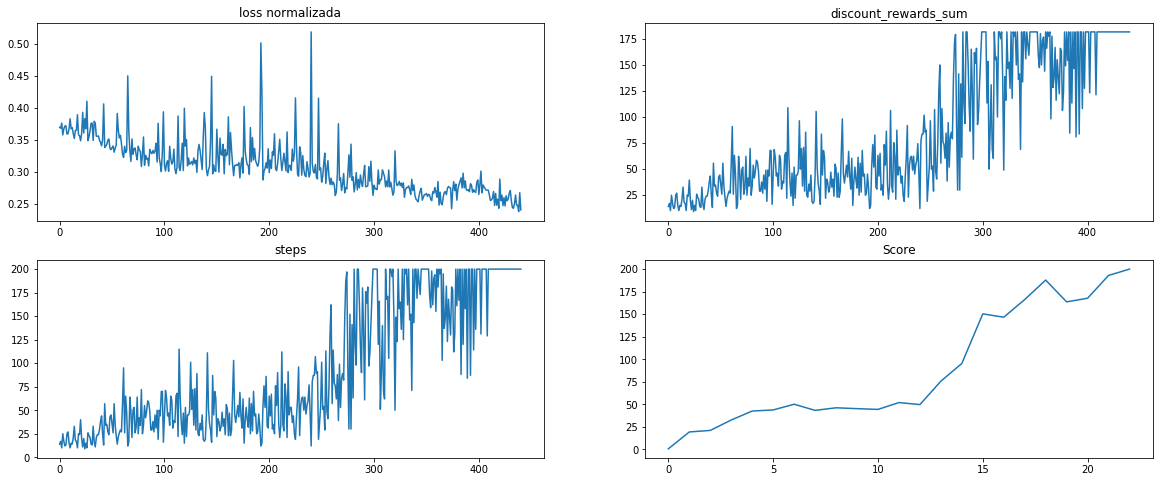

In [404]:
f, ax = plt.subplots(2, 2, figsize=(20,8))
ax = ax.flatten()
ax[0].set_title('loss normalizada')
ax[0].plot(np.array(loss_array)/np.array(steps).reshape(-1))
ax[1].set_title('discount_rewards_sum')
ax[1].plot(discounted_rewards_sum)
ax[2].set_title('steps')
ax[2].plot(steps)
ax[3].set_title('Score')
ax[3].plot(scores)
plt.show()

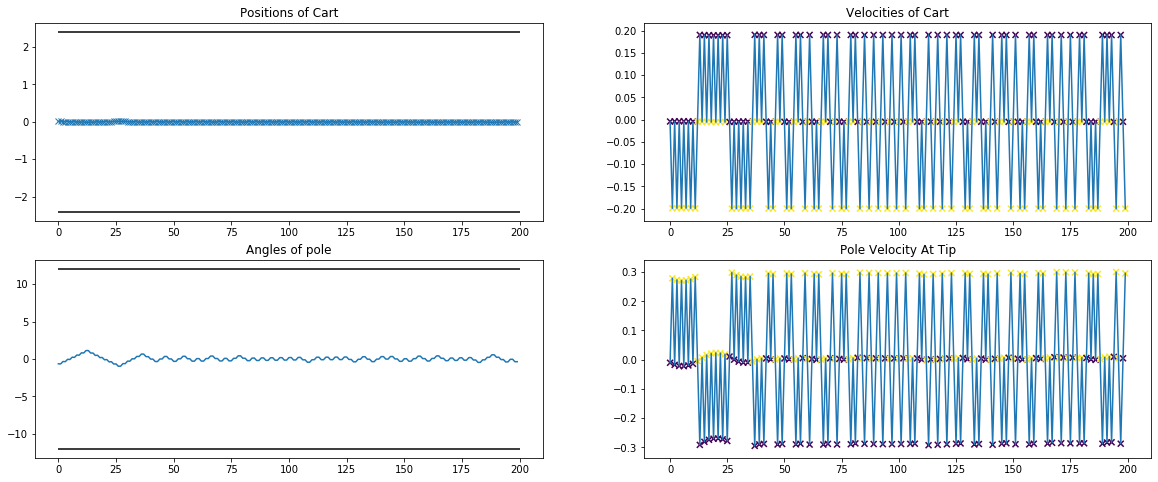

In [363]:
states, actions, rewards, reward_sum, discounted_rewards = run_episode(env, model, greedy=True)
plot_episode(*states.T, actions, show_pos_thres=True)

In [ ]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model, greedy=True), N=1000)

In [ ]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model, greedy=False), N=1000)

# Con batches

In [ ]:
def train_full_model(lr=0.1, max_num_episodes = 10000, episodes_batch_size = 50, training_epochs = 1, goal = 200, 
                     reset_model=True, hidden_layer_neurons = 128, verbose_period = 2, 
                     score_thres=10, states_means=None, states_stds=None,
                     model_train=None, model_predict=None, epsilon=1e-12):
    losses=[]
    if model_train is None:
        # Get model
        model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr)
    num_episode = 0
    i = 0
    
    while num_episode < max_num_episodes:
        # Get batch_size episodes for training
        batch_states, batch_actions, discounted_rewards, batch_probs = get_batch_data(env, model_predict, episodes_batch_size)
        if states_means is not None:
            batch_states = (batch_states - states_means)/states_stds
        # format data for NN
        discounted_rewards = apply_baselines(discounted_rewards)
        # discounted_rewards = np.ones((len(batch_actions), 1))*len(batch_states)/episodes_batch_size
        actions_train = actions_to_one_hot(batch_actions)
        hist = model_train.fit([batch_states, discounted_rewards], actions_train, 
                               batch_size=len(batch_states),
                               epochs=training_epochs, verbose=0)
        loss = hist.history['loss'][0]
        losses.append(loss)
        score = score_model(model_predict, env, score_thres)
        if (i%verbose_period) == 0:
            entropy = np.mean(-np.sum(np.log(batch_probs+epsilon)*batch_probs, axis=1)/np.log(2))
            print(f'{num_episode}) episode avg_len: {len(batch_states)/episodes_batch_size} loss: {loss:.3f}, score: {score}, entropy: {entropy:.3f}')
            # print(num_episode, np.mean(losses), score, entropy)
        if score >= goal:
            print("Solved in {} episodes!".format(num_episode))
            break
        num_episode+=episodes_batch_size
        i+=1
    return losses, model_train, model_predict

In [ ]:
losses, model_train, model_predict = train_full_model(lr=0.001, training_epochs = 1, hidden_layer_neurons = 128, 
                                                      episodes_batch_size=1, max_num_episodes=10000, 
                                                      score_thres = 10, 
                                                      verbose_period = 10,
                                                      #states_means=states_means, states_stds=states_stds,
                                                      model_train=None, model_predict=None)
#                                                       model_train=model_train, model_predict=model_predict)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(losses)

In [ ]:
states, actions, rewards, reward_sum, discounted_rewards = run_episode(env, model_predict, greedy=True)
plot_episode(*states.T, actions, show_pos_thres=True)

In [ ]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=True), N=1000)

In [ ]:
%time states_means, states_stds = get_observations_stats(env, lambda env: run_episode(env, model_predict, greedy=False), N=1000)

In [ ]:
# model_predict.save('model_predict-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')
# model_train.save('model_train-lr_0.005-training_epochs_1-hidden_layer_neurons_128-batch_size_50.hdf5')

In [ ]:
print_every

In [ ]:
training_episodes = 1
reward_sum = 0
model_train, model_predict = get_policy_model(env, hidden_layer_neurons, 0.01)
num_actions = env.action_space.n

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,1)
rewards = np.empty(0).reshape(0,1)
discounted_rewards = np.empty(0).reshape(0,1)

# Setting up our environment
observation = env.reset()

num_episode = 0

losses = []

while num_episode < num_episodes:
    # Append the observations to our batch
    state = np.reshape(observation, [1, dimen])
    
    predict = model_predict.predict([state])[0]
    action = np.random.choice(range(num_actions),p=predict)
    
    # Append the observations and outputs for learning
    states = np.vstack([states, state])
    actions = np.vstack([actions, action])
    
    # Determine the oucome of our action
    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    rewards = np.vstack([rewards, reward])
    
    if done:
        # Determine standardized rewards
        discounted_rewards_episode = discount_rewards(rewards, gamma)       
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])
        
        rewards = np.empty(0).reshape(0,1)

        if (num_episode + 1) % batch_size == 0:
            discounted_rewards -= discounted_rewards.mean()
            discounted_rewards /= discounted_rewards.std()
            discounted_rewards = discounted_rewards.squeeze()
            actions = actions.squeeze().astype(int)
           
            actions_train = np.zeros([len(actions), num_actions])
            actions_train[np.arange(len(actions)), actions] = 1
            for i in range(training_episodes):
                loss = model_train.train_on_batch([states, discounted_rewards], actions_train)
            losses.append(loss)

            # Clear out game variables
            states = np.empty(0).reshape(0,dimen)
            actions = np.empty(0).reshape(0,1)
            discounted_rewards = np.empty(0).reshape(0,1)


        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f}".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                np.mean(losses[-print_every:],)
            ))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()
        

In [ ]:
plt.plot(losses)

In [ ]:
env.close()